## Exploring HDF5 data file from GEDI Ecosystem Lidar
https://gedi.umd.edu/data/download/

We open the file using `h5py.File` in read mode, and store it in variable `hfd`

In [2]:
import h5py
import pandas as pd
import numpy as np
import matplotlib as plt
from jupyterthemes import jtplot

jtplot.style()

filename = 'GEDI01_B_2019108002011_O01959_T03909_02_003_01.h5'
hdf = h5py.File(filename, 'r')

A for loop is useful to see what is contained in hdf. Using `hdf.get`, we can access one of the groups contained in the file and store it in a variable, and check its contents again with a for loop. 

We can store each group in `hdf` in their respective variable to later on get their contents using functions. 

In [25]:
group1 = hdf.get('BEAM0000')
# have a quick look at the keys inside the group
# for key in group1:
#     print(key)

In [4]:
# exlore items in a group to see the different types etc. 
group1_items = list(group1.items())
print('Items in BEAM0000', group1_items)

Items in BEAM0000 [('all_samples_sum', <HDF5 dataset "all_samples_sum": shape (249810,), type "<u4">), ('ancillary', <HDF5 group "/BEAM0000/ancillary" (3 members)>), ('beam', <HDF5 dataset "beam": shape (249810,), type "<u2">), ('channel', <HDF5 dataset "channel": shape (249810,), type "|u1">), ('delta_time', <HDF5 dataset "delta_time": shape (249810,), type "<f8">), ('geolocation', <HDF5 group "/BEAM0000/geolocation" (39 members)>), ('geophys_corr', <HDF5 group "/BEAM0000/geophys_corr" (8 members)>), ('master_frac', <HDF5 dataset "master_frac": shape (249810,), type "<f8">), ('master_int', <HDF5 dataset "master_int": shape (249810,), type "<u4">), ('noise_mean_corrected', <HDF5 dataset "noise_mean_corrected": shape (249810,), type "<f8">), ('noise_stddev_corrected', <HDF5 dataset "noise_stddev_corrected": shape (249810,), type "<f8">), ('nsemean_even', <HDF5 dataset "nsemean_even": shape (249810,), type "<f4">), ('nsemean_odd', <HDF5 dataset "nsemean_odd": shape (249810,), type "<f4">

In [5]:
# for key in group1.keys():
#     print(type(group1.get(key)))

We can get a list of the datasets in a group and exclude some of the items in the group with the following function. We may want to leave out subrgoups or other datasets and we add them manually to the function:

In [6]:
def get_list(group): 
    result = []
    for key in group.keys():
        if key != 'ancillary':
            if key != 'geolocation':
                if key != 'geophys_corr':
                    result.append(key)
    return result

For a more concise result, we may want only a list of the items that are h5py datasets (excluding subgroups), for which we use the following function for a given group: 

In [30]:
def get_dataset_list(group):
    just_datasets = []
    for key in group.keys():
        if type(group.get(key)) == h5py._hl.dataset.Dataset:
            just_datasets.append(key)
    return just_datasets

One issue of the previus `get_dataset_list()` is that it will return all datasets and some of them when turned into an array have different lengths. For that we may want to only keep a list with datasets of equal length to make it easier to create a pandas DataFrame from a dictionary later. 

In [32]:
def get_dataset_list_len(group):
    pass

In [8]:
# get_datasets(group1)
# get_list(group1)

Using the result of the previous function that only gives us h5py datasets (of same lenght or not), we can get a list of those datasets, where each one is a NumPy array:

In [27]:
def get_array(group):
    all_data = []
    for key in group:
        for k in get_dataset_list(group):
            if key == k:
                all_data.append(np.array(group.get(key)))
    return all_data

As we mentioned earlier, not all dataset arrays have the same length, so we may want to get only the ones that have equal length. By checking the items in `group1`, we know most of them are of len = 249810, so that makes for a good collection. Let's get a list of arrays of that specific length, with the following function:

In [28]:
def get_array_len(group):
    all_data = []
    equal_len_arrays = []
    for key in group:
        for k in get_datasets(group):
            if key == k:
                all_data.append(np.array(group.get(key)))
    
    for array in all_data:
        if len(array) == 249810:
            equal_len_arrays.append(array)
    return equal_len_arrays

In [29]:
# get_array_len(group1)

We can now create a dictionary and store it in a variable, using our functions `get_datasets()` and `get_array_len()`

In [13]:
# create a dictionary containing each dataset as an array
data = dict(zip(get_datasets(group1), get_array(group1))) # fix for arrays of same length

In [15]:
# pd.DataFrame.from_dict(data)
# pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))


### Getting separate arrays and creating dataframes
We can get an array for each dataset contained in a group if we need to get them independently. We can then create a Pandas DataFrame for it, or for multiple arrays to be able to plot things or doing other analyses. 

In [33]:
# get single array of a dataset contained in the group
all_samples_sum = np.array(group1.get('all_samples_sum'))
delta_time = np.array(group1.get('delta_time'))

print(len(delta_time))

249810


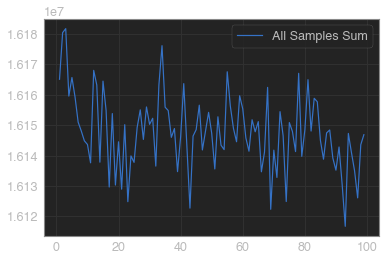

In [221]:
# make pandas dataframe from an array
df2 = pd.DataFrame(all_samples_sum)
df2.columns = ['All Samples Sum']
# print(df)
df2.iloc[1:100].plot() # plotting subset of df


In [81]:
# combine two (or more) datasets into one dataframe
df_from_arr = pd.DataFrame(data=[all_samples_sum, delta_time])
df3 = df_from_arr.T
df3.columns = ['all_samples_sum', 'delta_time']
df3

,all_samples_sum,delta_time
0,16167838.0,4.078333e+07
1,16165121.0,4.078333e+07
2,16180451.0,4.078333e+07
3,16181775.0,4.078333e+07
4,16159591.0,4.078333e+07
...,...,...
249805,16113674.0,4.078712e+07
249806,16111128.0,4.078712e+07
249807,16134410.0,4.078712e+07
249808,16103852.0,4.078712e+07
